In [8]:
# Detect environment
import sys

try:
    import google.colab
    IN_COLAB = True
    print("✅ Running on Google Colab")
except:
    IN_COLAB = False
    print("🖥️ Running locally")

print(f"Python: {sys.version.split()[0]}")

✅ Running on Google Colab
Python: 3.12.12


In [ ]:
# Install PyTorch Geometric
print("📦 Installing PyTorch Geometric...")
!pip install torch-geometric -q
print("✅ Installation complete!")

In [ ]:
# Import all required libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully")

In [ ]:
import numpy as np

# Example static schedule info for Colombo
colombo_schedule = {
    "bus_schedules": {
        "Kandy": {
            "normal":   [6.0, 10.0, 14.0, 18.0],
            "luxury":   [7.5, 13.0, 17.5],
            "semi-luxury": [8.0, 16.0],
            "highway":  [9.0, 15.0, 21.0]
        },
        "Galle": {
            "normal":   [5.5, 9.0, 18.0],
            "luxury":   [8.15, 14.0]
        },
    },
    "train_schedules": {
        "Kandy": {
            "express":  [7.25, 12.5, 18.0],
            "intercity": [6.0, 10.5, 16.0]
        }
    },
    "disruption_flag": 0
}

# Feature extraction helpers
def get_next_and_num_deps(times, now=12.0): 
    future = [t for t in times if t > now]
    if len(future) == 0:
        return 24.0, 0 
    next_dep = min(future)
    return next_dep - now, len(future)  

now = 12.0
next_norm, n_left_norm = get_next_and_num_deps(colombo_schedule["bus_schedules"]["Kandy"]["normal"], now)
print("Next normal bus to Kandy in hours:", next_norm, "; Departures left today:", n_left_norm)


Next normal bus to Kandy in hours: 2.0 ; Departures left today: 2


In [ ]:
import networkx as nx

# Define nodes
nodes = [
    {"name": "Colombo", "region": "urban", "popularity": 1.0, "schedule": colombo_schedule},
    {"name": "Kandy", "region": "hill", "popularity": 0.8},
    {"name": "Galle", "region": "coastal", "popularity": 0.7},
   
]

# Define edges (routes)
edges = [
    ("Colombo", "Kandy", {"mode": "bus", "distance": 120}),
    ("Colombo", "Kandy", {"mode": "train", "distance": 120}),
    ("Colombo", "Galle", {"mode": "bus", "distance": 120}),
    ("Kandy", "Galle", {"mode": "bus", "distance": 180}),
    
]

# Build the multigraph
G = nx.MultiGraph()
for node in nodes:
    G.add_node(node["name"], **node)
for u, v, attr in edges:
    G.add_edge(u, v, **attr)


In [5]:
import torch
from torch_geometric.data import Data

# Build node feature matrix (simple encoding for demo)
# Custom: for each node, extract e.g., region one-hot, popularity, disruption
region_map = {"urban": 0, "hill": 1, "coastal": 2, "rural": 3}
node2idx = {n["name"]: idx for idx, n in enumerate(nodes)}
node_feats = []
for node in nodes:
    region_vec = [0] * 4
    region_vec[region_map[node["region"]]] = 1
    popularity = node["popularity"]
    disruption = node.get("schedule", {}).get("disruption_flag", 0)
    # Example: append 'next normal bus to Kandy' as a feature (extend as needed)
    if "schedule" in node and "Kandy" in node["schedule"].get("bus_schedules", {}):
        next_norm, n_left_norm = get_next_and_num_deps(node["schedule"]["bus_schedules"]["Kandy"]["normal"], now=12.0)
    else:
        next_norm, n_left_norm = 24.0, 0
    node_feats.append(region_vec + [popularity, disruption, next_norm, n_left_norm])
X = torch.tensor(node_feats, dtype=torch.float)

# Build edge index and features (+ labels if supervised)
src, dst, edge_attrs = [], [], []
for u, v, data in G.edges(data=True):
    src.append(node2idx[u])
    dst.append(node2idx[v])
    mode = {"bus": 0, "train": 1, "tuk-tuk": 2}.get(data["mode"], 0)
    edge_attrs.append([data["distance"], mode])
edge_index = torch.tensor([src, dst], dtype=torch.long)
edge_attr = torch.tensor(edge_attrs, dtype=torch.float)
edge_labels = torch.ones(edge_index.shape[1])  # dummy; use real labels in practice

data = Data(x=X, edge_index=edge_index, edge_attr=edge_attr, y=edge_labels)


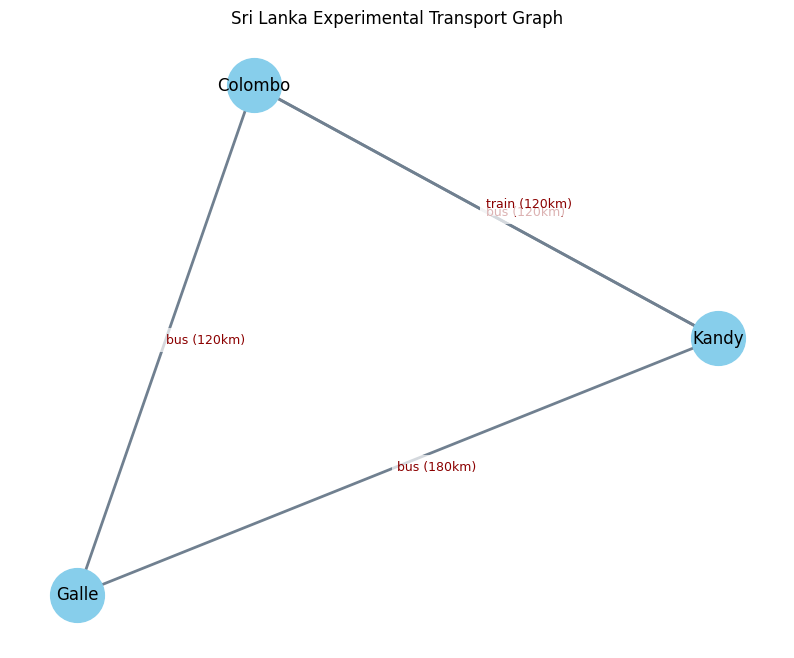

In [7]:
import matplotlib.pyplot as plt

# Build simple labels for edges: show mode and distance
edge_labels = {}
for u, v, key, data in G.edges(data=True, keys=True):
    label = f"{data['mode']} ({data['distance']}km)"
    edge_labels[(u, v, key)] = label

# Draw MultiGraph with labeled edges and nodes
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes; seed for reproducibility

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='skyblue')

# Draw edges (all modes)
nx.draw_networkx_edges(G, pos, width=2, edge_color='slategray')

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=12)

# For MultiGraph, use edge_key to handle parallel edges
for (u, v, key), label in edge_labels.items():
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    x, y = (x1 + x2) / 2, (y1 + y2) / 2
    plt.text(x, y + (key-0.5)*0.03, label, fontsize=9, color='darkred', 
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.title('Sri Lanka Experimental Transport Graph')
plt.axis('off')
plt.show()


In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class SimpleEdgeGNN(nn.Module):
    def __init__(self, node_in, hidden, edge_in):
        super().__init__()
        self.c1 = GCNConv(node_in, hidden)
        self.c2 = GCNConv(hidden, hidden)
        self.edge_mlp = nn.Sequential(
            nn.Linear(hidden*2 + edge_in, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, data):
        x = F.relu(self.c1(data.x, data.edge_index))
        x = F.relu(self.c2(x, data.edge_index))
        src, dst = data.edge_index
        edge_inputs = torch.cat([x[src], x[dst], data.edge_attr], dim=1)
        out = self.edge_mlp(edge_inputs).squeeze()
        return out
